In [1]:
#機器學習百日馬拉松期末考 - 貓狗圖像分類競賽
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Activation, Flatten
# from keras.applications.resnet50 import ResNet50
from keras.applications import VGG16

import os
import numpy as np
from PIL import Image
from os.path import join
from matplotlib import pyplot as plt
import random
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
#讀取影像資料
from PIL import Image
from os.path import join

data_dir = "./kaggle_dogcat"
train_data_dir=join(data_dir, "train")

dog_dir = join(train_data_dir, "dogs")
cat_dir = join(train_data_dir, "cats")
dog_imgs = [f for f in os.listdir(dog_dir) if os.path.isfile(join(dog_dir, f))]
cat_imgs = [f for f in os.listdir(cat_dir) if os.path.isfile(join(cat_dir, f))]

print("Total dog image #={}".format(len(dog_imgs)))
print("Total cat image #={}".format(len(cat_imgs)))

Total dog image #=2000
Total cat image #=2000


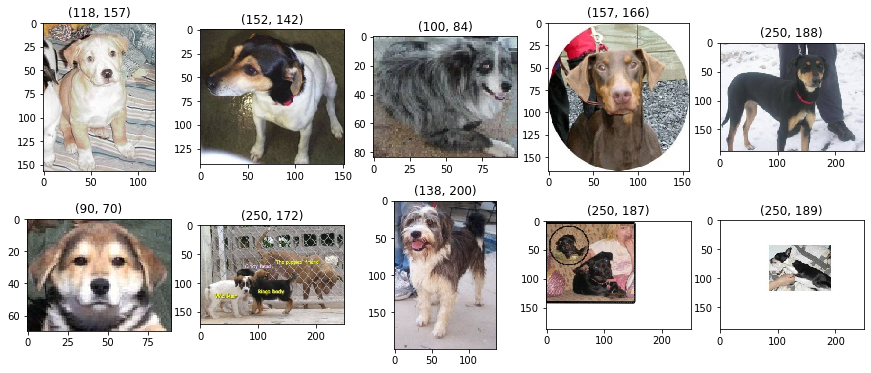

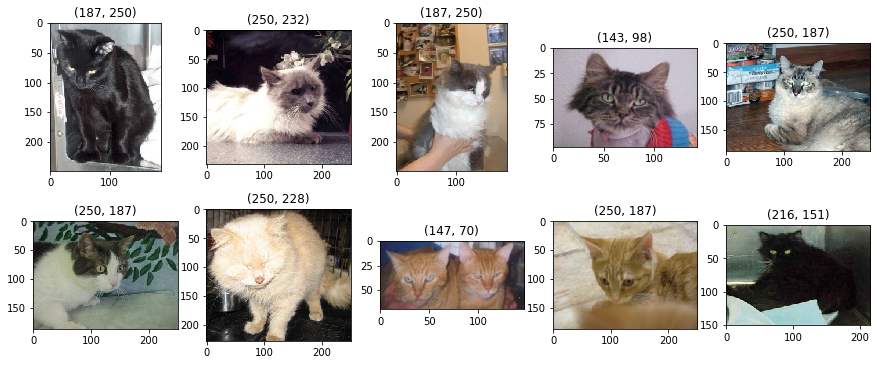

In [3]:
from PIL import Image
from matplotlib import pyplot as plt
import random

# show dog images 
def show_img(nrow, ncol, figsize, imgs, img_dir):
    plt.figure(figsize=figsize)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        img_file =imgs[random.randint(0,len(imgs))]
        img = Image.open(join(img_dir, img_file))
        plt.title(img.size)
        plt.imshow(img)
        
show_img(2,5, (15,6), dog_imgs, dog_dir)
show_img(2,5, (15,6), cat_imgs, cat_dir)

In [4]:
# cat, dog 兩類別
NUM_CLASSES = 2

# generator 每批次產生圖片數量
BATCH_SIZE = 128

FREEZE_LAYERS = 14

# 循環
EPOCHS = 15

# 模型輸出儲存的檔案
MODEL_FINAL = 'model.h5'
WEIGHTS_FINAL = 'model_weighs.h5'

WORKS = 3

# Target Image size
IMG_SIZE = (64,64)

# Train data dir
TRAIN_DATA_DIR = join(data_dir, "train")

# Validation data dir
VALIDATION_DATA_DIR = join(data_dir, "test")

# 訓練圖片數量
TRAIN_DATA_SIZE = 3000

# 驗證圖片數量
VALIDATION_DATA_SIZE = 1000

In [5]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')


for cls, idx in train_generator.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Found 4000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.
Class #0 = cats
Class #1 = dogs


In [6]:
#建立模型
# 建立 ResNet 模型
net = VGG16(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMG_SIZE[0],IMG_SIZE[1],3))
net.summary()

W0818 19:38:39.054601  3708 deprecation_wrapper.py:119] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 19:38:39.074602  3708 deprecation_wrapper.py:119] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 19:38:39.077602  3708 deprecation_wrapper.py:119] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 19:38:39.105604  3708 deprecation_wrapper.py:119] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0818 19:38:39.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [7]:
# 加入客製化層和輸出層
model = Sequential()
for layer in net.layers:
    model.add(layer)    
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax', name='softmax'))
                       
# 設定凍結與要進行訓練的網路層
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
model.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(model.summary())

W0818 19:38:39.822429  3708 deprecation.py:506] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0818 19:38:39.869432  3708 deprecation_wrapper.py:119] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       295168    
__________

In [8]:
# 訓練模型
history = model.fit_generator(train_generator,
                        steps_per_epoch = (TRAIN_DATA_SIZE//BATCH_SIZE)+1,
                        validation_data = validation_generator,
                        validation_steps = (VALIDATION_DATA_SIZE//BATCH_SIZE)+1,
                        epochs = EPOCHS,
                        verbose=1,
                        workers=WORKS)

W0818 19:38:40.082444  3708 deprecation.py:323] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
24/24 [==============================] - 57s 2s/step - loss: 0.7877 - acc: 0.5107
Epoch 2/15
24/24 [==============================] - 54s 2s/step - loss: 0.6858 - acc: 0.5866
Epoch 3/15
24/24 [==============================] - 53s 2s/step - loss: 0.6497 - acc: 0.6205
Epoch 4/15
24/24 [==============================] - 57s 2s/step - loss: 0.6148 - acc: 0.6628
Epoch 5/15
24/24 [==============================] - 58s 2s/step - loss: 0.5668 - acc: 0.7031
Epoch 6/15
24/24 [==============================] - 56s 2s/step - loss: 0.5486 - acc: 0.7157
Epoch 7/15
24/24 [==============================] - 56s 2s/step - loss: 0.5267 - acc: 0.7415
Epoch 8/15
24/24 [==============================] - 56s 2s/step - loss: 0.5248 - acc: 0.7438
Epoch 9/15
24/24 [==============================] - 58s 2s/step - loss: 0.5133 - acc: 0.7497
Epoch 10/15
24/24 [==============================] - 54s 2s/step - loss: 0.5120 - acc: 0.7463
Epoch 11/15
24/24 [==============================] - 54s 2s/step - lo

In [9]:
# 儲存訓練好的模型
model.save(MODEL_FINAL)
model.save_weights(WEIGHTS_FINAL)

In [10]:
# 訓練歷程
import pandas as pd
%matplotlib inline

df = pd.DataFrame(history.history)
# ax1 = df["acc", "val_acc"].plot()
# ax1.set_xlabel("Epoche")
# ax1.set_ylabel("Acc")

# ax2 = df["loss", "val_loss"].plot()
# ax2.set_xlabel("Epoche")
# ax2.set_ylabel("Loss")

In [28]:
#進行辨識
# Test data dir
TEST_DATA_DIR = join(data_dir, "test")
# TEST_DATA_IMG_DIR = join(TEST_DATA_DIR, "images")

# 測試圖片數量
TEST_DATA_SIZE =400

# 預測結果
SUBMISSION=join(data_dir, "cat_pretrain.csv")

In [31]:
# 進行預測

# Class 0 = cats
# Class 1 = dogs

clss =["cat", "dog"]
test_files = [f for f in os.listdir(TEST_DATA_DIR) if os.path.isfile(join(TEST_DATA_DIR, f))]
cat_prob=[]
fid=[]
for f in test_files:
    img = Image.open(join(TEST_DATA_DIR, f)).resize(IMG_SIZE)
    x = np.asarray(img)
    x = x/255
    x = np.expand_dims(x, axis = 0)
    pred_y = model.predict(x)[0]
    cat_prob.append(pred_y[0])
    fid.append(os.path.splitext(f)[0])
    idx = np.argmax(pred_y, axis=0)
    print("{} is {} {}".format(f, clss[idx] ,pred_y))
    
df = pd.DataFrame({"ID":fid, "Predicted":cat_prob})
df['ID'] = df['ID'].map(lambda x: os.path.splitext(os.path.split(x)[1])[0])
df.sort_values(by="ID").to_csv(SUBMISSION, index=False)

000.jpg is dog [0.1861651 0.8138349]
001.jpg is dog [0.08792937 0.91207063]
002.jpg is cat [0.9660731  0.03392684]
003.jpg is dog [0.19798277 0.8020173 ]
004.jpg is cat [0.78844804 0.21155193]
005.jpg is dog [0.4162995 0.5837005]
006.jpg is dog [0.2114803 0.7885197]
007.jpg is cat [0.58000124 0.4199988 ]
008.jpg is dog [0.2375382  0.76246184]
009.jpg is cat [0.8080325  0.19196752]
010.jpg is dog [0.01979431 0.98020566]
011.jpg is cat [0.97831845 0.02168156]
012.jpg is dog [0.28893876 0.7110612 ]
013.jpg is cat [0.93095577 0.06904417]
014.jpg is cat [0.80425817 0.19574182]
015.jpg is dog [0.14920473 0.85079527]
016.jpg is dog [0.01247726 0.9875228 ]
017.jpg is cat [0.7105838 0.2894162]
018.jpg is dog [0.11957914 0.88042086]
019.jpg is cat [0.8128185  0.18718147]
020.jpg is cat [0.89919424 0.10080577]
021.jpg is cat [0.64516836 0.35483164]
022.jpg is cat [0.6188342  0.38116586]
023.jpg is cat [0.99135286 0.0086471 ]
024.jpg is cat [0.80426663 0.19573335]
025.jpg is dog [0.21900928 0.7809

213.jpg is dog [0.03430432 0.9656957 ]
214.jpg is dog [0.04924941 0.95075065]
215.jpg is dog [0.0054477 0.9945523]
216.jpg is dog [0.06691801 0.93308204]
217.jpg is dog [0.40379468 0.59620535]
218.jpg is dog [0.29391053 0.70608944]
219.jpg is cat [0.9087726  0.09122746]
220.jpg is dog [0.10472892 0.8952711 ]
221.jpg is dog [0.00516579 0.9948342 ]
222.jpg is dog [0.00244419 0.99755573]
223.jpg is cat [0.94765556 0.05234447]
224.jpg is cat [0.8443562  0.15564384]
225.jpg is dog [0.03874335 0.9612566 ]
226.jpg is cat [0.9522099  0.04779014]
227.jpg is cat [0.62240475 0.37759525]
228.jpg is dog [0.16419706 0.8358029 ]
229.jpg is dog [0.03392871 0.9660713 ]
230.jpg is dog [0.1532213 0.8467787]
231.jpg is cat [0.7871285  0.21287146]
232.jpg is dog [0.291876 0.708124]
233.jpg is dog [3.1090176e-04 9.9968910e-01]
234.jpg is dog [0.01850277 0.9814973 ]
235.jpg is dog [0.20302446 0.7969756 ]
236.jpg is cat [0.5938489 0.4061512]
237.jpg is dog [0.03611174 0.9638883 ]
238.jpg is dog [0.06427456 0.